# Personalized Medicine: Redefining Cancer Treatment¶
Predict the effect of Genetic Variants to enable Personalized Medicine The problem link:https://www.kaggle.com/c/msk-redefining-cancer-treatment This was launched by Memorial Sloan Kettering Cancer Center (MSKCC).Log Loss is the recomended scoring matrix.

# Steps to take
- problem statement
- loading data
- analysing the data
- processing the data
- feature extraction
- training classifier
- testing
- conclusion

# Used Libraries


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.sparse import  hstack
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score,classification_report,confusion_matrix


 # Loading the data

In [2]:
# start with loading data
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)


# analysing the data

In [3]:
# Here we try to see nature of data,get some information and statistics about the data.
#data_variants
print(data_variants.head(5))
print(data_variants.info())
print(data_variants.describe())
print(data_variants.shape)
print(data_variants.columns)

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB
None
                ID        Class
count  3321.000000  3321.000000
mean   1660.000000     4.365854
std     958.834449     2.309781
min       0.000000     1.000000
25%     830.000000     2.000000
50%    1660.000000     4.000000
75%    2490.000000     7.000000
max    3320.000000     9.000000
(3321, 4)
Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


In [4]:
#data_Text
print(data_text.head(5))
print(data_text.info())
print(data_text.describe())
print(data_text.shape)
print(data_text.columns)

   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB
None
                ID
count  3321.000000
mean   1660.000000
std     958.834449
min       0.000000
25%     830.000000
50%    1660.000000
75%    2490.000000
max    3320.000000
(3321, 2)
Index(['ID', 'TEXT'], dtype='object')


# Data Processsing

In [5]:
#merging both text and variants data base on Id
result_data = pd.merge(data_variants, data_text,on='ID', how='left')
result_data=result_data[['ID','Gene','Variation','TEXT','Class']]
print(result_data.head(5)) #viewing the resulting data
result_data.dtypes

   ID    Gene             Variation  \
0   0  FAM58A  Truncating Mutations   
1   1     CBL                 W802*   
2   2     CBL                 Q249E   
3   3     CBL                 N454D   
4   4     CBL                 L399V   

                                                TEXT  Class  
0  Cyclin-dependent kinases (CDKs) regulate a var...      1  
1   Abstract Background  Non-small cell lung canc...      2  
2   Abstract Background  Non-small cell lung canc...      2  
3  Recent evidence has demonstrated that acquired...      3  
4  Oncogenic mutations in the monomeric Casitas B...      4  


ID            int64
Gene         object
Variation    object
TEXT         object
Class         int64
dtype: object

In [6]:
# checking and handling Missing data 
result_data[result_data.isnull().any(axis=1)]


,ID,Gene,Variation,TEXT,Class
1109,1109,FANCA,S1088F,NaN,1
1277,1277,ARID5B,Truncating Mutations,NaN,1
1407,1407,FGFR3,K508M,NaN,6
1639,1639,FLT1,Amplification,NaN,6
2755,2755,BRAF,G596C,NaN,7


In [7]:
# Imputing Missing data
# there are only missing Text we will replace them with a cobination of gene and variant
result_data.loc[result_data['TEXT'].isnull(),'TEXT'] = result_data['Gene'] +' '+result_data['Variation']
# verifying our imputation
result_data[result_data.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT,Class


In [8]:
# Checking the distribution of each paramater 
TEXT_Distribution=result_data.groupby('Class').TEXT.count()
Gene_Distribution=result_data.groupby('Class').Gene.count()
Variation_Distribution=result_data.groupby('Class').Variation.count()
print(TEXT_Distribution)
print(Gene_Distribution)
print(Variation_Distribution)

Class
1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
Name: TEXT, dtype: int64
Class
1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
Name: Gene, dtype: int64
Class
1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
Name: Variation, dtype: int64


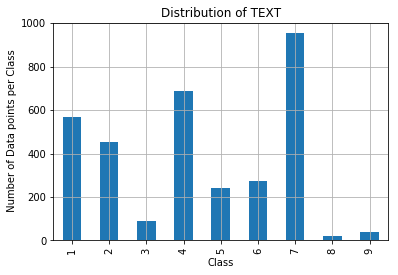

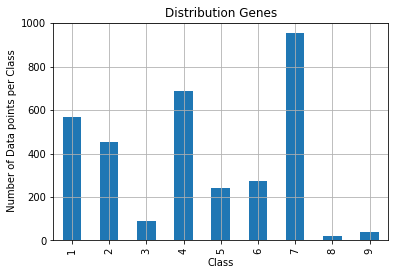

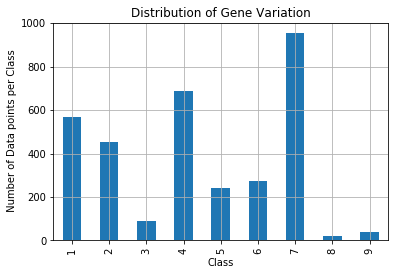

In [9]:
# Visualising using a bar shart
TEXT_Distribution.plot(kind='bar' )
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of TEXT')
plt.grid()
plt.show()

Gene_Distribution.plot(kind='bar' )
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution Genes')
plt.grid()
plt.show()

Variation_Distribution.plot(kind='bar' )
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of Gene Variation')
plt.grid()
plt.show()

## Cleaning the data in order to metigate the problem of dimesionality
-by applying feature engineering


In [10]:
# some functions used
# replace space within the gene and variation columns with _
def GeneColumn(Gene):
    Gene.replace('\s+', '_')
    return Gene

def VariationColumn(Variation):
    Variation.replace('\s+', '_')
    return Variation
# replacing special characters with a space and double space with sing space
def TEXTColumn(TEXT):
    TEXT.replace('[^a-zA-Z0-9\n]', ' ')
    TEXT.replace('\s+',' ',)
    #Stemmer
    Wln=WordNetLemmatizer()
    TEXT=[Wln.lemmatize(word) for word in TEXT]
    

In [11]:
# Running the function
GeneColumn(result_data.Gene)
VariationColumn(result_data.Variation)
TEXTColumn(result_data.TEXT)

# Feature Extraction
- CountVectorizer
- TfidfVectorizer

In [12]:
vectorizer = CountVectorizer()
vecGene= vectorizer.fit_transform(result_data.Gene)
# Checking the shape of the data
print(vecGene.shape)
# checking the Column 
vectorizer.get_feature_names()


(3321, 263)


['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'f

In [13]:
vectorizer = CountVectorizer()
vecVariation= vectorizer.fit_transform(result_data.Variation)
# Checking the shape of the data
print(vecVariation.shape)
# checking the Column 
vectorizer.get_feature_names()

(3321, 3021)


['11',
 '126',
 '13',
 '17',
 '19',
 '1_2009trunc',
 '20',
 '2010_2471trunc',
 '256_286trunc',
 '385_418del',
 '422_605trunc',
 '51',
 '533_534del',
 '534_536del',
 '550_592del',
 '560_561inser',
 '596_619splice',
 '6a',
 '963_d1010splice',
 '981_1028splice',
 'a1020v',
 'a1022e',
 'a1065t',
 'a1066v',
 'a1099t',
 'a111p',
 'a1131t',
 'a113_splice',
 'a1170v',
 'a11_g12insga',
 'a1200v',
 'a120s',
 'a121e',
 'a121p',
 'a121v',
 'a122',
 'a1234t',
 'a126d',
 'a126g',
 'a126s',
 'a126v',
 'a134d',
 'a1374v',
 'a1459p',
 'a146t',
 'a146v',
 'a148t',
 'a149p',
 'a1519t',
 'a151t',
 'a159t',
 'a161s',
 'a161t',
 'a1669s',
 'a1685s',
 'a1701p',
 'a1708e',
 'a1708v',
 'a171v',
 'a1752p',
 'a1752v',
 'a1789s',
 'a1789t',
 'a1823t',
 'a1830t',
 'a1843p',
 'a1843t',
 'a18d',
 'a197t',
 'a19v',
 'a2034v',
 'a205t',
 'a209t',
 'a211d',
 'a232v',
 'a2351g',
 'a23e',
 'a2425t',
 'a246p',
 'a263v',
 'a2643g',
 'a2717s',
 'a272v',
 'a2770t',
 'a290t',
 'a298t',
 'a339v',
 'a347t',
 'a349p',
 'a34d',
 

In [14]:
#We can still do some processing here by removing stop words,features that occurs less than 3 times and setting the maximum features to 5000
vectorizer = TfidfVectorizer(stop_words='english',min_df=3)
vecTEXT= vectorizer.fit_transform(result_data.TEXT)
#Checking data shape
print(vecTEXT.shape)
# checking the Column 
vectorizer.get_feature_names()

(3321, 70444)


['00',
 '000',
 '0000',
 '00000001',
 '0000001',
 '000001',
 '000002',
 '000007',
 '00001',
 '0000112',
 '0000208',
 '00002644',
 '00003',
 '00005',
 '00006',
 '0000614',
 '0000645',
 '00006559',
 '00008',
 '0000839',
 '00009',
 '0001',
 '0001042',
 '0001171',
 '00014',
 '000148',
 '00016',
 '000182',
 '00019',
 '0001a',
 '0001â',
 '0002',
 '0002050',
 '0002079',
 '00021',
 '0002158',
 '000245',
 '00025',
 '00028',
 '00029',
 '0003',
 '0003073',
 '0003254',
 '00034',
 '0003529',
 '000357129',
 '000369266',
 '00037',
 '0004',
 '0004376',
 '00047',
 '0004798',
 '0004920',
 '0005',
 '0005044',
 '0005159',
 '0005214',
 '0005266',
 '0005309',
 '0005355',
 '000588',
 '0006',
 '0007',
 '0008',
 '00088',
 '0009',
 '00092',
 '000g',
 '000xg',
 '000â',
 '000ã',
 '001',
 '0010',
 '00103',
 '0011',
 '001100',
 '001105',
 '0012',
 '001210',
 '0012a',
 '0013',
 '0014',
 '0014b',
 '0015',
 '0016',
 '00161',
 '001635',
 '0017',
 '0018',
 '001810',
 '0019',
 '0019â',
 '001a',
 '001acd4',
 '001acd8',
 '

In [15]:
#combing all features using hstack and compresing using compressed sparse row format
result=hstack([vecGene, vecVariation,vecTEXT]).toarray()

In [16]:
# setting the y_true
y =np.array(result_data['Class'].values)
#Checking what type of data we have in our Class column
result_data['Class'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [17]:
# spliting data into test and trainning
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.2, random_state=0)


# Machine Learning

## Naive Biase

In [ ]:
#MultinomialNB
model = MultinomialNB()
alphas = [1.e-10,1.e-5, 1.e-3,1.e-1,0.1, 0.5, 1]
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas),cv=3)
grid.fit(X_train, y_train)
print(grid)
#result summary
print(grid.best_score_)
print(grid.best_estimator_.alpha)

 

In [ ]:
#predicting using best alpha
alpha=grid.best_estimator_.alpha
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
#CalibratedClassifier
# fit a model
model = MultinomialNB(alpha=grid.best_estimator_.alpha)
calibrated = CalibratedClassifierCV(model, method='sigmoid',cv=3)
calibrated.fit(X_train, y_train)
# predict probabilities
pred_probs = calibrated.predict_proba(X_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, pred_probs))
print("Number of missclassified point :", np.count_nonzero((calibrated.predict(X_test)- y_test))/y_test.shape[0])


## K Nearest Neighbour Classification

In [ ]:
# KNearest Neigbour
model =KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid ={'n_neighbors':[1,4,7,10,13]}
#use gridsearch to test all values for n_neighbors
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=3)
#fit model to data
grid.fit(X_train, y_train)
print(grid)
#result summary
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)


In [ ]:
#predicting using best n_neighbors
n_neighbors=grid.best_estimator_.n_neighbors
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
#CalibratedClassifier
# fit a model
model = MultinomialNB(n_neighbors=grid.best_estimator_.n_neighbors)
calibrated = CalibratedClassifierCV(model, method='sigmoid',cv=3)
calibrated.fit(X_train, y_train)
# predict probabilities
pred_probs = calibrated.predict_proba(X_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, pred_probs))
print("Number of missclassified point :", np.count_nonzero((calibrated.predict(X_test)- y_test))/y_test.shape[0])


# Linear Classifier SGD

In [20]:
#linear_model.SGDClassifier
model = linear_model.SGDClassifier(class_weight='balanced', penalty='l2', loss='log', random_state=42)
alphas = [1.e-10,1.e-5, 1.e-3,1.e-1,0.1, 0.5, 1]
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas),cv=3)
grid.fit(X_train, y_train)
print(grid)
#result summary
print(grid.best_score_)
print(grid.best_estimator_.alpha)

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_it

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-10, 1e-05, 0.001, 0.1, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.6321536144578314
1e-05


In [21]:
#predicting using best alpha
alpha=grid.best_estimator_.alpha
model =linear_model.SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.649624060150376
[[ 66   2   0  19   8   7   0   0   1]
 [  0  69   0   1   2   3  17   0   0]
 [  1   1   6   8   2   0   6   0   0]
 [ 24   2   3 103   7   2   2   0   1]
 [  7   2   1   8  30   4   6   0   2]
 [  5   5   3   2   3  29   4   0   0]
 [  6  42   0   3   6   2 124   0   0]
 [  0   1   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   1   1   4]]
              precision    recall  f1-score   support

           1       0.61      0.64      0.62       103
           2       0.56      0.75      0.64        92
           3       0.46      0.25      0.32        24
           4       0.72      0.72      0.72       144
           5       0.52      0.50      0.51        60
           6       0.62      0.57      0.59        51
           7       0.78      0.68      0.72       183
           8       0.50      0.50      0.50         2
           9       0.50      0.67      0.57         6

   micro avg       0.65      0.65      0.65       665
   macro avg       0.58      0.59 

In [22]:
#CalibratedClassifier
# fit a model
model = linear_model.SGDClassifier(class_weight='balanced', penalty='l2', loss='log', random_state=42,alpha=grid.best_estimator_.alpha)
calibrated = CalibratedClassifierCV(model, method='sigmoid',cv=3)
calibrated.fit(X_train, y_train)
# predict probabilities
pred_probs = calibrated.predict_proba(X_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, pred_probs))
print("Number of missclassified point :", np.count_nonzero((calibrated.predict(X_test)- y_test))/y_test.shape[0])

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_it

Log Loss : 1.0298348126904542
Number of missclassified point : 0.33383458646616543


# Linear Classifier SVM

In [ ]:
#linear_model.SGDClassifier
model = SVC()
C = [1.e-10,1.e-5, 1.e-3,1.e-1,0.1, 0.5, 1]
grid = GridSearchCV(estimator=model, param_grid=dict(C=C),cv=3)
grid.fit(X_train, y_train)
print(grid)
#result summary
print(grid.best_score_)
print(grid.best_estimator_.C)

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

In [ ]:
#predicting using best alpha
alpha=grid.best_estimator_.C
model =SVC()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
#CalibratedClassifier
# fit a model
model = SVC()
calibrated = CalibratedClassifierCV(model, method='sigmoid',cv=3)
calibrated.fit(X_train, y_train)
# predict probabilities
pred_probs = calibrated.predict_proba(X_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, pred_probs))
print("Number of missclassified point :", np.count_nonzero((calibrated.predict(X_test)- y_test))/y_test.shape[0])

# Random Forest


In [21]:
#RandomForestClassifier
model=RandomForestClassifier()
# using a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
# trainning over the grid
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False,verbose=1)
grid_search.fit(X_train, y_train)
print("grid search report")
print(best_grid = grid_search.best_estimator_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", Future

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 49.5min finished
C:\Users\Gerald\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


grid search report


NameError: name 'report' is not defined

In [22]:
best_grid = grid_search.best_estimator_

In [23]:
print(best_grid)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [26]:
#prediction with best grid search params
model=RandomForestClassifier(best_grid)
y_pred=grid_search.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(score)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.6150375939849624
[[ 65   2   0  15   5   5  11   0   0]
 [  6  36   0   2   1   1  46   0   0]
 [  1   0   9   5   2   0   7   0   0]
 [ 27   5   3  97   0   0  12   0   0]
 [ 18   2   1   8  18   1  12   0   0]
 [  6   2   2   1   3  29   8   0   0]
 [  7  11   0  11   3   0 151   0   0]
 [  0   1   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   2   1   3]]
              precision    recall  f1-score   support

           1       0.50      0.63      0.56       103
           2       0.61      0.39      0.48        92
           3       0.60      0.38      0.46        24
           4       0.70      0.67      0.69       144
           5       0.56      0.30      0.39        60
           6       0.81      0.57      0.67        51
           7       0.61      0.83      0.70       183
           8       0.50      0.50      0.50         2
           9       1.00      0.50      0.67         6

   micro avg       0.62      0.62      0.62       665
   macro avg       0.65      0.53

In [30]:
#CalibratedClassifier
# fit a model
model=RandomForestClassifier(min_samples_leaf=1,max_features=1,n_estimators=10)
calibrated = CalibratedClassifierCV(model, method='sigmoid',cv=3)
calibrated.fit(X_train, y_train)
# predict probabilities
pred_probs = calibrated.predict_proba(X_test)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, pred_probs))
print("Number of missclassified point :", np.count_nonzero((calibrated.predict(X_test)- y_test))/y_test.shape[0])

Log Loss : 1.1808325870409506
Number of missclassified point : 0.3819548872180451


In [52]:
# Predicting a Class
test_point=6
test_data=X_test[test_point].reshape(1, -1)
prediction=grid_search.predict(test_data)
prediction_probabilities=calibrated.predict_proba(test_data)
Actual_result=y_test[test_point]
print('prediction: ',prediction)
print('prediction_probabilities: ',prediction_probabilities)
print('Actual_result:',Actual_result)

prediction:  [1]
prediction_probabilities:  [[0.42580632 0.08371896 0.02191428 0.18178263 0.06007569 0.02803446
  0.1818259  0.00933916 0.00750261]]
Actual_result: 1
